## Going Deeper #6 : Weat score를 통해 영화 장르 별로 영화 구분과의 편향성 측정해 보기
---

In [3]:
# 영화 시놉시스 전체 코퍼스에서 명사만 뽑아내기
from konlpy.tag import Okt
import os
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

In [4]:
# 뽑아낸 명사로 워드 임베딩 만들기
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  

In [5]:
model.wv.most_similar(positive=['범인'])

[('증거', 0.9492014646530151),
 ('단서', 0.9327113032341003),
 ('살인마', 0.9304184317588806),
 ('범', 0.9144657850265503),
 ('누명', 0.9087026119232178),
 ('지목', 0.9086408615112305),
 ('추적', 0.9038002490997314),
 ('용의자', 0.9033242464065552),
 ('살인자', 0.9021294713020325),
 ('연쇄', 0.8983655571937561)]

In [6]:
model.wv.most_similar(positive=['부자'])

[('재희', 0.9368932843208313),
 ('민재', 0.9264337420463562),
 ('새아빠', 0.9263002872467041),
 ('새어머니', 0.9237778782844543),
 ('영수', 0.9228717088699341),
 ('상우', 0.922825813293457),
 ('상민', 0.9214584231376648),
 ('미연', 0.9195935726165771),
 ('식구', 0.917548656463623),
 ('둘이서', 0.9155746698379517)]

+ 부자는 돈이 많은 사람과 아버지와 아들의 관계인 부자 대표적인 두가지 뜻이 있으나 유사 단어를 보면 돈이 많은 사람이라는 의미는 임베딩 되지 않은 것 같다.

In [7]:
model.wv.most_similar(positive=['친구'])

[('절친', 0.7102771401405334),
 ('단짝', 0.69734787940979),
 ('마리', 0.6593639850616455),
 ('강아지', 0.6538172364234924),
 ('여자친구', 0.6484124660491943),
 ('현수', 0.6061012148857117),
 ('오빠', 0.60569167137146),
 ('남학생', 0.6054321527481079),
 ('누나', 0.6020680069923401),
 ('소원', 0.6001246571540833)]

In [8]:
# 파일 읽어서 뭉치로 만들기 함수
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [9]:
# 영화 구분 별 코퍼스 만들기
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [10]:
# 영화 구분별 tf-idf 만들기
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [11]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 spart matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 spart matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [12]:
# 중복 단어 제거하고 상위 15개 단어 뽑아내기
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

---

In [13]:
# 전체 장르로 비교해 보기
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [14]:
# 모든 코퍼스 읽어서 뭉치기
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [35]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


---
#### 타 장르들에서 상대적으로 빈번하게 사용된 단어와 중복되는 단어를 모두 제거하는 경우

In [36]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    temp_ = []    # 나머지 장르의 단어들 묶어놓기 위한 임시 리스트 만들어 두기
    j = 0
    for k in range(len(w)):
        if k != i:  # 현재 살펴보는 장르 이외의 장르만을 살펴보기
            for l in range(100):  # 장르 별로 100개 단어만 모으기
                temp_.append(vectorizer.get_feature_names()[w[k][l][0]]) # 임시 리스트 채우기
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            if vectorizer.get_feature_names()[w[i][j][0]] not in temp_: # 만들어 둔 임시 리스트에 없을 때만 attr로 합치기
                attr.append(vectorizer.get_feature_names()[w[i][j][0]])
                print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 외계, 행성, 시스템, 생명체, 스타크, 리플리, 과학자, 파괴, 켈빈, 컨트, 수퍼맨, 외계인, 분파, 연구, 개발, 
가족: 아주르, 낙타, 씨제이, 동구, 슈이트, 마갈, 미아, 펠리칸, 벤트, 케이시, 크리스마스, 최호, 혜지, 유나, 테리, 
공연: 실황, 올레, 오텔로, 리골레토, 백작, 프레, 베르디, 비바, 콘서트, 백작부인, 반니, 아리아, 미노, 차이코프스키, 라다, 
공포(호러): 악령, 좀비, 저주, 일행, 악몽, 귀신, 저택, 현상, 사라, 영혼, 살인마, 기운, 그날, 치료, 분홍신, 
기타: 뉴미디어, 아시아나, 이미지, 상영작, 지하철, 청소년, 유럽, 포럼, 메트로, 단편영화, 실험영화, 대화, 거리, 광주, 프라이드, 
다큐멘터리: 다큐, 다큐멘터리, 기록, 카메라, 투쟁, 인디다큐페스티발, 지금, 현재, 문화, 건축, 인터뷰, 중국, 변화, 운동, 자연, 
드라마: 시절, 고향, 청년, 자기, 이상, 선택, 전주, 이유, 동네, 그것, 자리, 오늘, 선생님, 소개, 대신, 
멜로로맨스: 애인, 남자친구, 선배, 커플, 고백, 동거, 이혼, 시아버지, 만남, 은밀, 첫사랑, 직장, 언니, 형부, 매일, 
뮤지컬: 뮤지컬, 에스메랄다, 충무로, 모차르트, 니웨, 바흐, 페뷔스, 프롤, 모도, 제루샤, 샤오캉, 데이비, 팬텀, 크리스틴, 노트르담, 
미스터리: 민혁, 미스터리, 방독면, 소설, 랭던, 몰카, 혼란, 지목, 누군가, 거미숲, 작가, 사이먼, 누구, 의사, 수연, 
범죄: 한길수, 프랭크, 파푸아, 금고, 테러범, 강도, 마샨, 거래, 달러, 검사, 철중, 도미, 사기꾼, 범행, 폭력, 
사극: 조선, 신기전, 아가멤논, 황제, 루안, 하선, 윤서, 트로이, 세자, 허균, 노준, 채선, 신재효, 히파티아, 권력, 
서부극(웨스턴): 서부, 보안관, 벌린, 카우보이, 그레이프바인, 헨리, 개릿, 무법자, 프린트, 마적, 태구, 현상금, 분노, 버질, 랜던, 
성인물(에로): 에피소드, 유이, 욕구불만, 손님, 유우

+ 다른 장르의 최다 사용 100위 단어들을 뭉친 리스트와 중복되지 않는 단어만 뽑아내다 보니까 해당 장르를 잘 대표하는 단어 보다는 이름이나 지명 등 특이한 단어들만 뽑힌 경향이 있다.
  + 타 장르 100위 안에 들어온 단어가 아니라 좀더 적은 숫자의 단어를 고려하거나 재귀적으로 다른 장르의 15개 리스트에 없는 단어를 뽑아내도록 하면 좀 더 단어를 잘 뽑아낼 수 있지 않을까?

In [42]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [43]:
import numpy as np
from numpy.linalg import norm

def cos_sim(i, j):
    return np.dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B#, c_a, c_b

def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

In [44]:
A = np.array([model.wv[word] for word in target_art])
B = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        X = np.array([model.wv[word] for word in attributes[i]])
        Y = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [45]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] > 1.1 or matrix[i][j] < -1.1:
            print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -1.1605864
SF 공포(호러) -1.402906
SF 드라마 -1.2080541
SF 멜로로맨스 -1.6718521
SF 미스터리 -1.1806108
SF 성인물(에로) -1.4193608
SF 스릴러 -1.3042936
SF 판타지 -1.1572127
가족 기타 1.2948235
가족 다큐멘터리 1.314106
가족 전쟁 1.1637437
공연 공포(호러) -1.1596596
공연 다큐멘터리 1.117467
공연 멜로로맨스 -1.6332604
공연 성인물(에로) -1.1764216
공포(호러) 기타 1.5411352
공포(호러) 다큐멘터리 1.58289
공포(호러) 뮤지컬 1.1593755
공포(호러) 범죄 1.2229029
공포(호러) 사극 1.2103957
공포(호러) 액션 1.3515661
공포(호러) 전쟁 1.5093457
기타 드라마 -1.3866233
기타 멜로로맨스 -1.765005
기타 미스터리 -1.3887948
기타 범죄 -1.1238037
기타 서부극(웨스턴) -1.2515095
기타 성인물(에로) -1.5802133
기타 스릴러 -1.4867778
기타 어드벤처 -1.2197456
기타 코미디 -1.2399864
기타 판타지 -1.3031602
다큐멘터리 드라마 -1.431556
다큐멘터리 멜로로맨스 -1.8065478
다큐멘터리 미스터리 -1.4489292
다큐멘터리 범죄 -1.190717
다큐멘터리 서부극(웨스턴) -1.291944
다큐멘터리 성인물(에로) -1.6388826
다큐멘터리 스릴러 -1.5455356
다큐멘터리 어드벤처 -1.2554369
다큐멘터리 코미디 -1.26322
다큐멘터리 판타지 -1.3270181
드라마 멜로로맨스 -1.1999084
드라마 전쟁 1.2915727
멜로로맨스 뮤지컬 1.4917586
멜로로맨스 미스터리 1.440819
멜로로맨스 범죄 1.7015426
멜로로맨스 사극 1.592926
멜로로맨스 서부극(웨스턴) 1.3158168
멜로로맨스 성인물(에로) 1.1966015
멜로로

+ 멜로로맨스 영화는 대부분의 영화보다 예술영화에 가깝다.
+ SF영화, 기타 영화, 다큐멘터리 영화는 대부분의 영화보다 일반영화에 가깝다.

<AxesSubplot:>

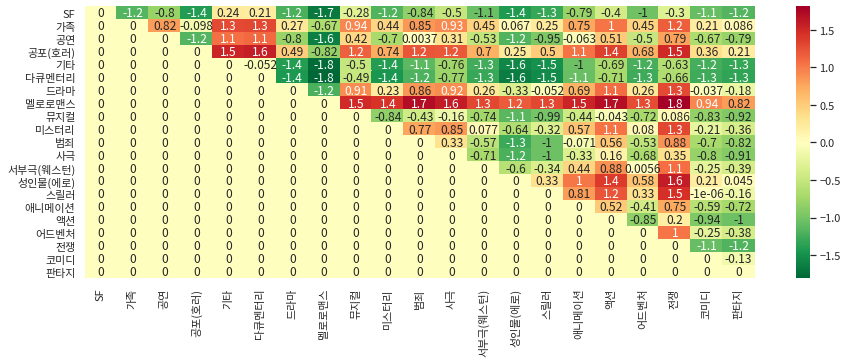

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(0)

plt.rcParams["figure.figsize"] = (15,5)

# 한글 지원 폰트
sns.set(font="Noto Sans CJK JP")

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

--- 
#### 중복을 제거하지 않은 경우

In [93]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

In [48]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

In [49]:
A = np.array([model.wv[word] for word in target_art])
B = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        X = np.array([model.wv[word] for word in attributes[i]])
        Y = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [50]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] > 1.1 or matrix[i][j] < -1.1:
            print(genre_name[i], genre_name[j],matrix[i][j])

SF 멜로로맨스 -1.3077248
공포(호러) 다큐멘터리 1.1535559
기타 멜로로맨스 -1.1748604
다큐멘터리 멜로로맨스 -1.4744347
다큐멘터리 미스터리 -1.266122
다큐멘터리 성인물(에로) -1.2149781
다큐멘터리 스릴러 -1.1361125
멜로로맨스 범죄 1.2152698
멜로로맨스 서부극(웨스턴) 1.1166185
멜로로맨스 애니메이션 1.1692377
멜로로맨스 전쟁 1.4022679


+ 여전히 멜로는 범죄, 서부극, 애니메이션, 전쟁, 다큐멘터리, 기타 보다 예술 영화에 가깝다.

<AxesSubplot:>

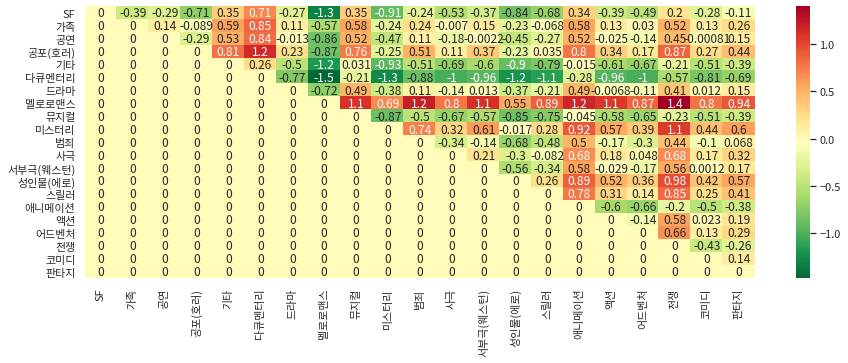

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(0)

plt.rcParams["figure.figsize"] = (15,5)

# 한글 지원 폰트
sns.set(font="Noto Sans CJK JP")

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

---
#### 생각한 점
+ 중복되는 단어를 모두 제거하이 이름과 같은 특이한 단어만 남은 장르가 있었다.
+ 중복을 제거하니 weat 값과 히트맵은 보다 명확하게 나왔다. 
+ 다만 이름만 남은 성인영화 같은 경우 중복을 제거하지 않았을 때가 해당 장르를 더 잘 표현하는 단어 셋이 나왔던 것 같다.
+ 단순히 중복되는 단어를 모두 제거하는 것 보다는 다른 기준으로 단어 셋을 선택하도록 해야할 것 같다.